## Detalle sobre este notebook (fv_iteraperiodos_para_max_betweenness):
* **OBJETIVO:** Dado un aspecto y un % de nodos a considerar, se itera en los períodos 14 al 21, y se informa el período en que el betweenness es máximo

#### Librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from networkx.algorithms import community
import community as community_louvain


#### Cargar df_5_extended

In [2]:
df_5_extended = pd.read_excel('df_5_extended.xlsx')
df_5_extended.head()

,countryname,ventana_5,per101,per102,per103,per104,per105,per106,per107,per108,...,per606_1,per606_2,per607_1,per607_2,per607_3,per608_1,per608_2,per608_3,per703_1,per703_2
0,Albania,15,3.113815,0.00000,1.559835,2.046771,0.331285,1.674371,4.632186,5.169904,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,Albania,16,3.716797,0.00000,0.051879,3.519091,0.015910,0.579077,4.971347,1.981720,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,Albania,17,2.392570,0.00000,0.000000,2.757403,0.026619,0.023948,3.523162,1.452779,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,Argentina,14,0.000000,0.00000,4.619213,0.448618,0.828036,0.338070,2.955090,0.000000,...,7.595332,0.0,0.326532,0.0,0.000000,0.0,0.0,0.0,2.495280,0.0
4,Argentina,16,0.254185,0.02014,0.725611,1.406834,0.100835,1.720736,5.478894,3.932102,...,4.494125,0.0,0.443809,0.0,0.809128,0.0,0.0,0.0,2.573783,0.0


In [3]:
df_5_extended.shape

(1407, 144)

In [4]:
# cargar Analytical_Data
df_AD = pd.read_excel('data/Analytical_Data.xlsx')
df_AD.head()


,Dominio,Nombre_Dominio,Variable_per,Detalle_Dominio
0,Domain_1,External Relations,per101,Foreign Special Relationships: Positive
1,Domain_1,External Relations,per102,Foreign Special Relationships: Negative
2,Domain_1,External Relations,per103,Anti-Imperialism
3,Domain_1,External Relations,per104,Military: Positive
4,Domain_1,External Relations,per105,Military: Negative


In [5]:
all_per_variables = [col for col in df_5_extended.columns if col.startswith('per')]
all_per_variables

['per101',
 'per102',
 'per103',
 'per104',
 'per105',
 'per106',
 'per107',
 'per108',
 'per109',
 'per110',
 'per201',
 'per202',
 'per203',
 'per204',
 'per301',
 'per302',
 'per303',
 'per304',
 'per305',
 'per401',
 'per402',
 'per403',
 'per404',
 'per405',
 'per406',
 'per407',
 'per408',
 'per409',
 'per410',
 'per411',
 'per412',
 'per413',
 'per414',
 'per415',
 'per416',
 'per501',
 'per502',
 'per503',
 'per504',
 'per505',
 'per506',
 'per507',
 'per601',
 'per602',
 'per603',
 'per604',
 'per605',
 'per606',
 'per607',
 'per608',
 'per701',
 'per702',
 'per703',
 'per704',
 'per705',
 'per706',
 'per1011',
 'per1012',
 'per1013',
 'per1014',
 'per1015',
 'per1016',
 'per1021',
 'per1022',
 'per1023',
 'per1024',
 'per1025',
 'per1026',
 'per1031',
 'per1032',
 'per1033',
 'per2021',
 'per2022',
 'per2023',
 'per2031',
 'per2032',
 'per2033',
 'per2041',
 'per3011',
 'per3051',
 'per3052',
 'per3053',
 'per3054',
 'per3055',
 'per4011',
 'per4012',
 'per4013',
 'per4014',


In [6]:
len(all_per_variables)

142

### MATRIZ DE ASPECTOS

In [7]:
# Crear el DataFrame 'df_aspectos' con los aspectos y las variables asociadas
data_aspectos = {
    'aspecto': ['Democracia_o_Gob.Autoritario_de_un_solo_partido'],
    'var_1': ['per201'],
    'var_2': ['per202'],
    'var_3': ['per2021'],  # None indica que no hay una tercera variable para el aspecto
    'var_4': [None]  
}

df_aspectos = pd.DataFrame(data_aspectos)

# Mostrar el DataFrame 'df_aspectos' para verificar su contenido
display(df_aspectos)

,aspecto,var_1,var_2,var_3,var_4
0,Democracia_o_Gob.Autoritario_de_un_solo_partido,per201,per202,per2021,None


#### Años en cada período

In [8]:
# cargar períodos
df_ventana_5 = pd.read_excel('data/Ventana_5.xlsx')
df_ventana_5

,agno,ventana
0,1920,1
1,1921,1
2,1922,1
3,1923,1
4,1924,1
...,...,...
99,2019,20
100,2020,21
101,2021,21
102,2022,21


#### Calculamos la similaridad tanto con correlación como con distancia euclideana

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean
from scipy.stats import spearmanr
from collections import defaultdict
import itertools


In [10]:
def calcular_similitudes_todos_paises(df, df_aspectos, tipo_similitud, periodo):
    """Calcula la similaridad entre todos los países para un aspecto específico y un período usando Pearson o Euclidean."""
    similarity_results = defaultdict(list)

    # Filtrar el dataframe para el período específico
    df = df[df['ventana_5'] == periodo]
    
    for _, row_aspecto in df_aspectos.iterrows():
        aspecto = row_aspecto['aspecto']
        variables = row_aspecto[['var_1', 'var_2', 'var_3', 'var_4']].dropna().tolist()

        # Filtrar datos de todos los países con las columnas relevantes
        columnas_relevantes = ['countryname', 'ventana_5'] + variables
        df_filtered = df[columnas_relevantes].copy()

        # Calcular similitudes entre todos los pares de países
        for (idx1, row1), (idx2, row2) in itertools.combinations(df_filtered.iterrows(), 2):
            country_period_1 = f"{row1['countryname']}_{row1['ventana_5']}"
            country_data_1 = row1[variables].astype(float)

            country_period_2 = f"{row2['countryname']}_{row2['ventana_5']}"
            country_data_2 = row2[variables].astype(float)

            # Asignar similaridad de cero si uno de los países tiene todos los valores en cero
            if country_data_1.sum() == 0 or country_data_2.sum() == 0:
                similarity = 0  
            else:
                if tipo_similitud == 'pearson':
                    # Calcular la correlación de Pearson
                    corr = country_data_1.corr(country_data_2, method='pearson')
                    # print(f"Pearson/ {aspecto} / {country_period_1} / {country_period_2} / {corr}")
                    similarity = 0 if pd.isna(corr) else abs(corr)
                elif tipo_similitud == 'euclidean':
                    dist = euclidean(country_data_1, country_data_2)
                    similarity = 1 / (1 + dist) if not np.isnan(dist) else 0

            similarity_results[(aspecto, country_period_1, country_period_2)].append(similarity)

    # Convertir a DataFrame
    final_results = {
        key: np.mean(values) for key, values in similarity_results.items()
    }

    df_similarities = pd.DataFrame(
        list(final_results.items()), 
        columns=['Aspecto_Country_Period1_Period2', 'Similarity']
    )
    df_similarities[['Aspecto', 'Country_Period_1', 'Country_Period_2']] = pd.DataFrame(
        df_similarities['Aspecto_Country_Period1_Period2'].tolist(), index=df_similarities.index
    )
    df_similarities.drop('Aspecto_Country_Period1_Period2', axis=1, inplace=True)

    # Eliminar duplicados
    df_similarities = df_similarities.groupby(['Country_Period_1', 'Country_Period_2'], as_index=False).agg({'Similarity': 'mean'})
    
    return df_similarities


#### Generamos las Redes, Comunidades y Métricas de Centralidad

In [11]:
def generar_red_y_calcular_metricas(df_similarity, aspecto, tipo_similitud, porcentaje, periodo):
    """
    Genera una red de similaridad, calcula las métricas de centralidad, 
    y analiza las comunidades detectadas para un aspecto específico.
    """
    resumen = {'Aspecto': aspecto, 'Criterio': tipo_similitud}
    
    # Obtener los años "Desde" y "Hasta" para el período dado
    desde_hasta_df = df_ventana_5[df_ventana_5['ventana'] == periodo]
    desde = desde_hasta_df['agno'].min()
    hasta = desde_hasta_df['agno'].max()
    
    # Filtrar los x% enlaces con mayor similaridad
    df_similarity = df_similarity.sort_values(by='Similarity', ascending=False)
    top_x_percent = int(len(df_similarity) * (porcentaje / 100))
    df_top_similarity = df_similarity.head(top_x_percent)

    # Redondear la similaridad a 4 decimales
    df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
    
    # Crear el grafo
    G = nx.Graph()
    for _, row in df_top_similarity.iterrows():
        nodo_1 = row['Country_Period_1']
        nodo_2 = row['Country_Period_2']
        G.add_edge(nodo_1, nodo_2, weight=row['Similarity'])
    
    # Configuración de colores de los enlaces según la fuerza del enlace
    weights = nx.get_edge_attributes(G, 'weight').values()
    norm = plt.Normalize(vmin=min(weights), vmax=max(weights))
    colors = [cm.coolwarm(norm(weight)) for weight in weights]

    # Visualización de la red de similaridad
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, k=0.5, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, edge_color=colors, width=2)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(f'Red de Similitud - {aspecto}\nPeríodo {periodo} ({desde}-{hasta}) ({porcentaje}% enlaces más fuertes) - {tipo_similitud}')
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Fuerza del Enlace')
    plt.show()

    # Clustering y cálculo de métricas de centralidad
    partition = community.louvain_communities(G, weight='weight')
    resumen['Num_Comunidades'] = len(partition)
    print(f"Se identificaron {resumen['Num_Comunidades']} clusters para el aspecto '{aspecto}'.")

    # Visualización del gráfico de comunidades
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    colors = cm.rainbow(np.linspace(0, 1, resumen['Num_Comunidades']))  # Colores para cada comunidad
    for i, comm in enumerate(partition):
        nx.draw_networkx_nodes(G, pos, nodelist=list(comm), node_size=300, node_color=[colors[i]], label=f'Comunidad {i}')
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=2)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(f'Comunidades detectadas - {aspecto}\nPeríodo {periodo} ({desde}-{hasta}) ({porcentaje}% enlaces más fuertes) - {tipo_similitud}')
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Fuerza del Enlace')
    plt.legend(loc="best")
    plt.show()

    # Identificar la comunidad de Chile
    chile_node = f"Chile_{periodo}"
    chile_community = None
    for i, comm in enumerate(partition):
        if chile_node in comm:
            chile_community = comm
            resumen['Comunidad_Chile'] = i
            resumen['Num_Paises_Chile_Comunidad'] = len(chile_community)
            print(f"Chile pertenece a la Comunidad {i}, que incluye {len(chile_community)} países:")
            print(sorted(list(chile_community)))
            break
    if not chile_community:
        resumen['Comunidad_Chile'] = None
        resumen['Num_Paises_Chile_Comunidad'] = 0

    # Listar otras comunidades
    for i, comm in enumerate(partition):
        if chile_node not in comm:
            print(f"Comunidad {i} incluye {len(comm)} países:")
            print(sorted(list(comm)))

    # Cálculo de métricas de centralidad
    degree = nx.degree_centrality(G)
    betweenness = nx.betweenness_centrality(G, weight='weight')
    closeness = nx.closeness_centrality(G)
    eigenvector = nx.eigenvector_centrality(G, max_iter=1000)

    # Resumen de centralidades
    centralities = pd.DataFrame({
        'Nodo': list(degree.keys()),
        'Degree_Centrality': list(degree.values()),
        'Betweenness_Centrality': list(betweenness.values()),
        'Closeness_Centrality': list(closeness.values()),
        'Eigenvector_Centrality': list(eigenvector.values())
    })
    
    resumen['Num_Paises'] = len(centralities)
    for metric in ['Degree_Centrality', 'Betweenness_Centrality', 'Closeness_Centrality', 'Eigenvector_Centrality']:
        resumen[f'Promedio_{metric}'] = round(centralities[metric].mean(), 4)
        resumen[f'Std_{metric}'] = round(centralities[metric].std(), 4)
        resumen[f'Max_{metric}'] = round(centralities[metric].max(), 4)

    return resumen, centralities


#### Ejecución


=== Análisis para el período: 14 ===


--- Analizando aspecto: Democracia_o_Gob.Autoritario_de_un_solo_partido ---



/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9888/1363358268.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9888/1363358268.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


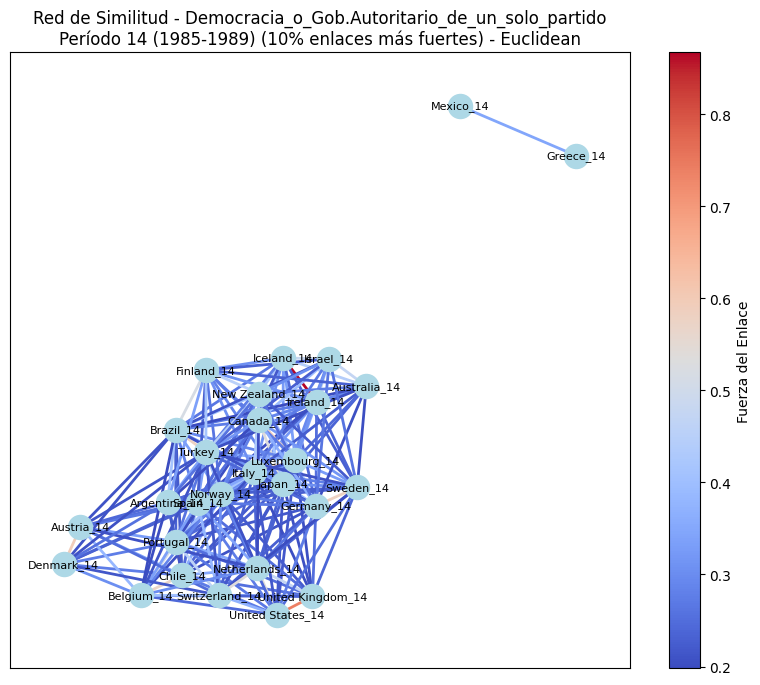

Se identificaron 3 clusters para el aspecto 'Democracia_o_Gob.Autoritario_de_un_solo_partido'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9888/1363358268.py:61: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


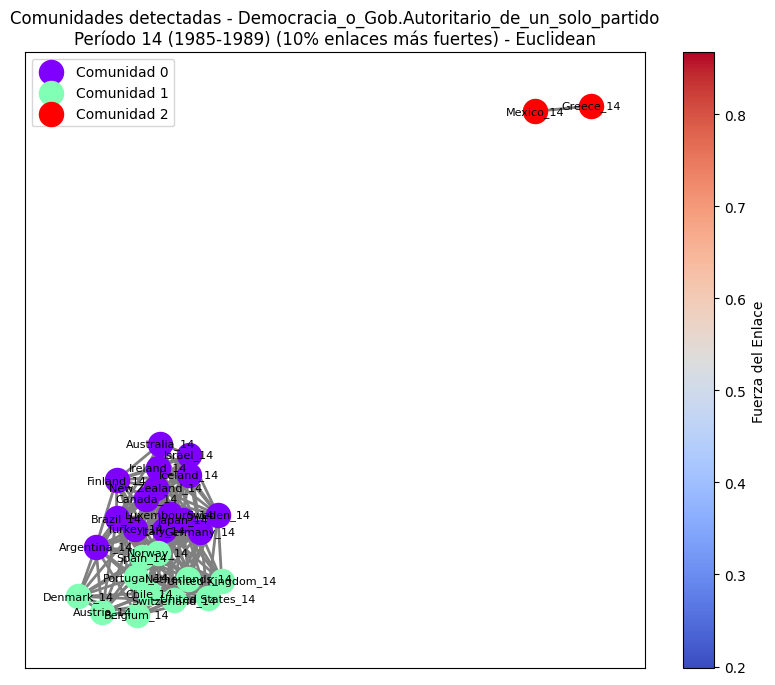

Chile pertenece a la Comunidad 1, que incluye 11 países:
['Austria_14', 'Belgium_14', 'Chile_14', 'Denmark_14', 'Netherlands_14', 'Norway_14', 'Portugal_14', 'Spain_14', 'Switzerland_14', 'United Kingdom_14', 'United States_14']
Comunidad 0 incluye 15 países:
['Argentina_14', 'Australia_14', 'Brazil_14', 'Canada_14', 'Finland_14', 'Germany_14', 'Iceland_14', 'Ireland_14', 'Israel_14', 'Italy_14', 'Japan_14', 'Luxembourg_14', 'New Zealand_14', 'Sweden_14', 'Turkey_14']
Comunidad 2 incluye 2 países:
['Greece_14', 'Mexico_14']

=== Análisis para el período: 15 ===


--- Analizando aspecto: Democracia_o_Gob.Autoritario_de_un_solo_partido ---



/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9888/1363358268.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9888/1363358268.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


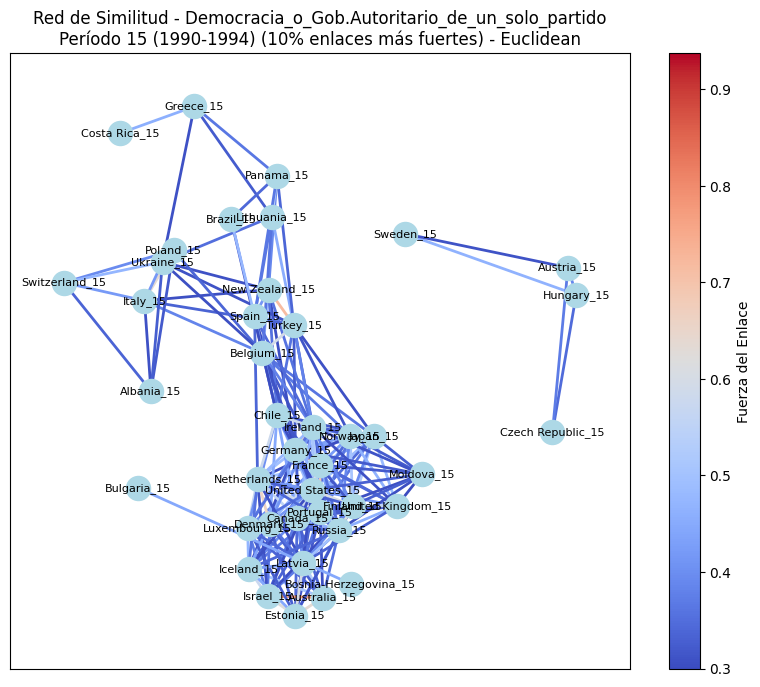

Se identificaron 5 clusters para el aspecto 'Democracia_o_Gob.Autoritario_de_un_solo_partido'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9888/1363358268.py:61: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


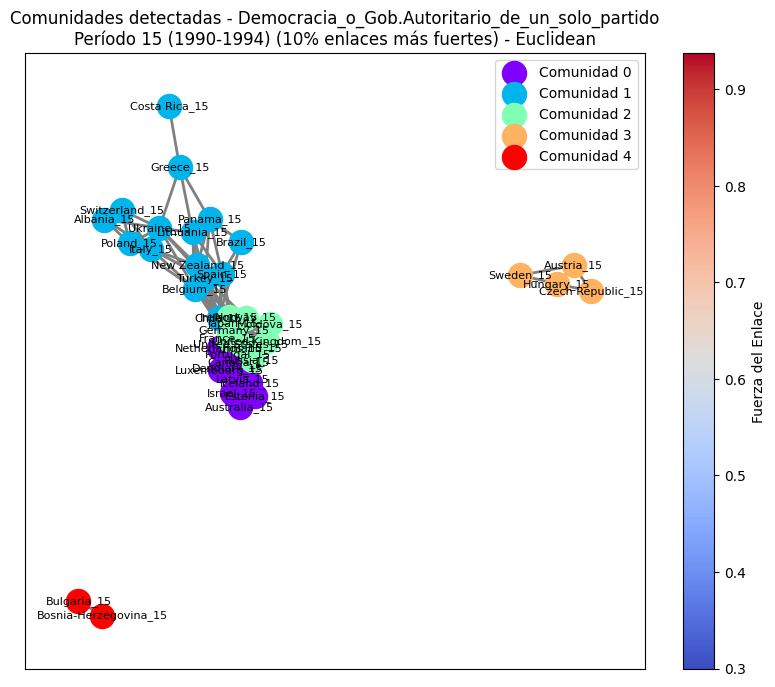

Chile pertenece a la Comunidad 1, que incluye 15 países:
['Albania_15', 'Belgium_15', 'Brazil_15', 'Chile_15', 'Costa Rica_15', 'Greece_15', 'Italy_15', 'Lithuania_15', 'New Zealand_15', 'Panama_15', 'Poland_15', 'Spain_15', 'Switzerland_15', 'Turkey_15', 'Ukraine_15']
Comunidad 0 incluye 10 países:
['Australia_15', 'Canada_15', 'Denmark_15', 'Estonia_15', 'Iceland_15', 'Israel_15', 'Latvia_15', 'Luxembourg_15', 'Netherlands_15', 'Portugal_15']
Comunidad 2 incluye 10 países:
['Finland_15', 'France_15', 'Germany_15', 'Ireland_15', 'Japan_15', 'Moldova_15', 'Norway_15', 'Russia_15', 'United Kingdom_15', 'United States_15']
Comunidad 3 incluye 4 países:
['Austria_15', 'Czech Republic_15', 'Hungary_15', 'Sweden_15']
Comunidad 4 incluye 2 países:
['Bosnia-Herzegovina_15', 'Bulgaria_15']

=== Análisis para el período: 16 ===


--- Analizando aspecto: Democracia_o_Gob.Autoritario_de_un_solo_partido ---



/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9888/1363358268.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9888/1363358268.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


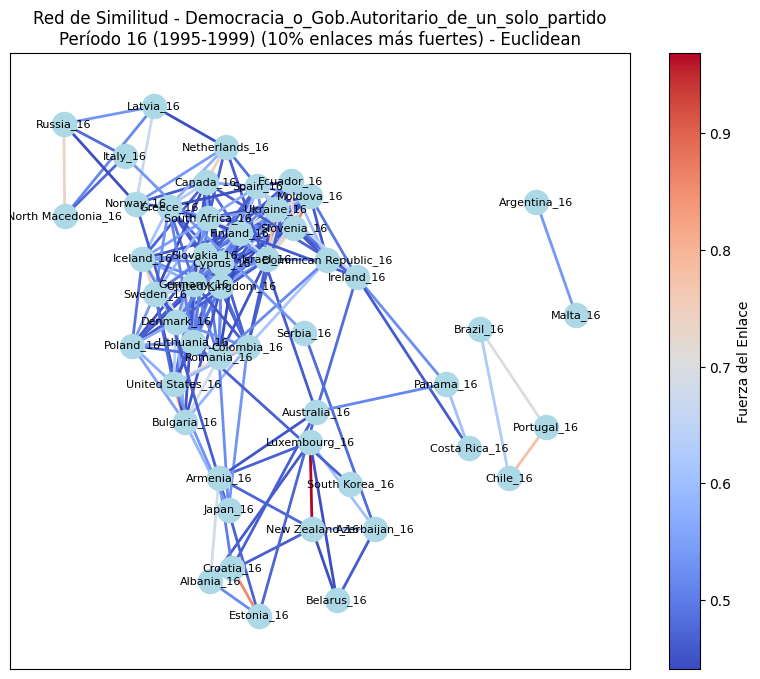

Se identificaron 6 clusters para el aspecto 'Democracia_o_Gob.Autoritario_de_un_solo_partido'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9888/1363358268.py:61: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


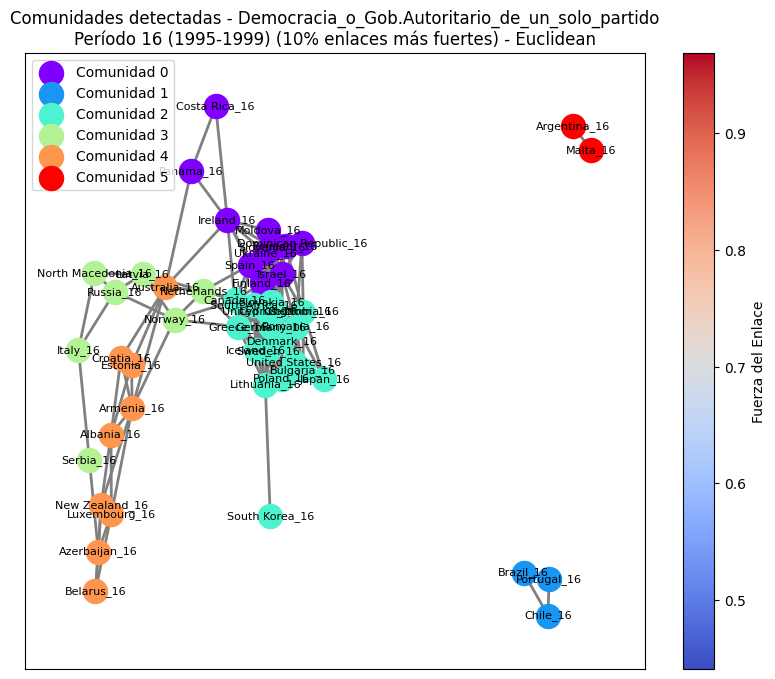

Chile pertenece a la Comunidad 1, que incluye 3 países:
['Brazil_16', 'Chile_16', 'Portugal_16']
Comunidad 0 incluye 11 países:
['Costa Rica_16', 'Dominican Republic_16', 'Ecuador_16', 'Finland_16', 'Ireland_16', 'Israel_16', 'Moldova_16', 'Panama_16', 'Slovenia_16', 'Spain_16', 'Ukraine_16']
Comunidad 2 incluye 18 países:
['Bulgaria_16', 'Canada_16', 'Colombia_16', 'Cyprus_16', 'Denmark_16', 'Germany_16', 'Greece_16', 'Iceland_16', 'Japan_16', 'Lithuania_16', 'Poland_16', 'Romania_16', 'Slovakia_16', 'South Africa_16', 'South Korea_16', 'Sweden_16', 'United Kingdom_16', 'United States_16']
Comunidad 3 incluye 7 países:
['Italy_16', 'Latvia_16', 'Netherlands_16', 'North Macedonia_16', 'Norway_16', 'Russia_16', 'Serbia_16']
Comunidad 4 incluye 9 países:
['Albania_16', 'Armenia_16', 'Australia_16', 'Azerbaijan_16', 'Belarus_16', 'Croatia_16', 'Estonia_16', 'Luxembourg_16', 'New Zealand_16']
Comunidad 5 incluye 2 países:
['Argentina_16', 'Malta_16']

=== Análisis para el período: 17 ===



/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9888/1363358268.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9888/1363358268.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


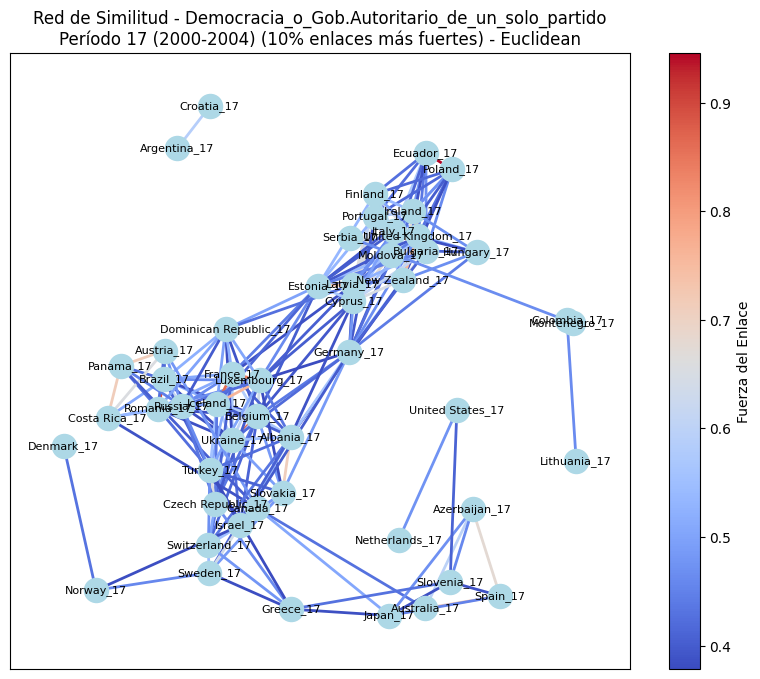

Se identificaron 7 clusters para el aspecto 'Democracia_o_Gob.Autoritario_de_un_solo_partido'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9888/1363358268.py:61: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


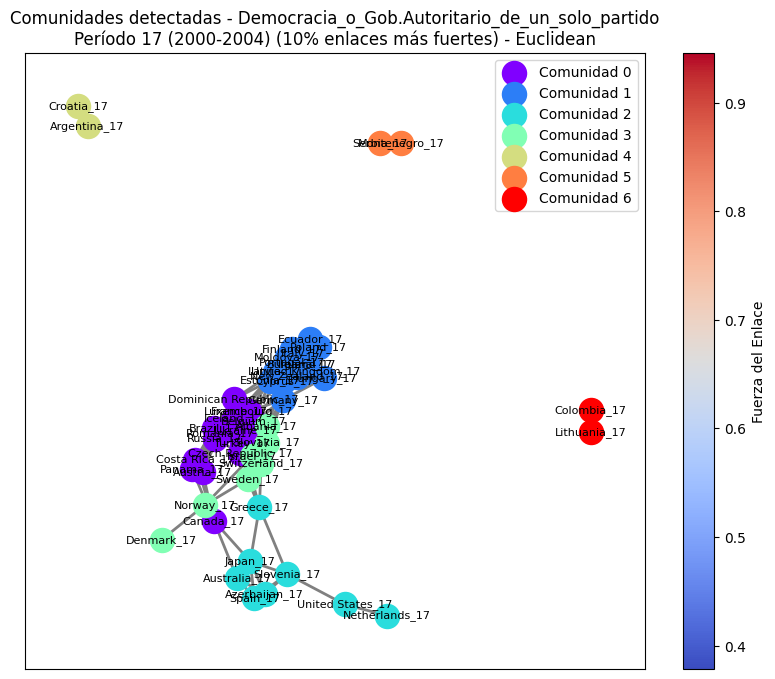

Comunidad 0 incluye 15 países:
['Austria_17', 'Belgium_17', 'Brazil_17', 'Canada_17', 'Costa Rica_17', 'Czech Republic_17', 'Dominican Republic_17', 'France_17', 'Iceland_17', 'Luxembourg_17', 'Panama_17', 'Romania_17', 'Russia_17', 'Turkey_17', 'Ukraine_17']
Comunidad 1 incluye 15 países:
['Bulgaria_17', 'Cyprus_17', 'Ecuador_17', 'Estonia_17', 'Finland_17', 'Germany_17', 'Hungary_17', 'Ireland_17', 'Italy_17', 'Latvia_17', 'Moldova_17', 'New Zealand_17', 'Poland_17', 'Portugal_17', 'United Kingdom_17']
Comunidad 2 incluye 8 países:
['Australia_17', 'Azerbaijan_17', 'Greece_17', 'Japan_17', 'Netherlands_17', 'Slovenia_17', 'Spain_17', 'United States_17']
Comunidad 3 incluye 7 países:
['Albania_17', 'Denmark_17', 'Israel_17', 'Norway_17', 'Slovakia_17', 'Sweden_17', 'Switzerland_17']
Comunidad 4 incluye 2 países:
['Argentina_17', 'Croatia_17']
Comunidad 5 incluye 2 países:
['Montenegro_17', 'Serbia_17']
Comunidad 6 incluye 2 países:
['Colombia_17', 'Lithuania_17']

=== Análisis para el

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9888/1363358268.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9888/1363358268.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


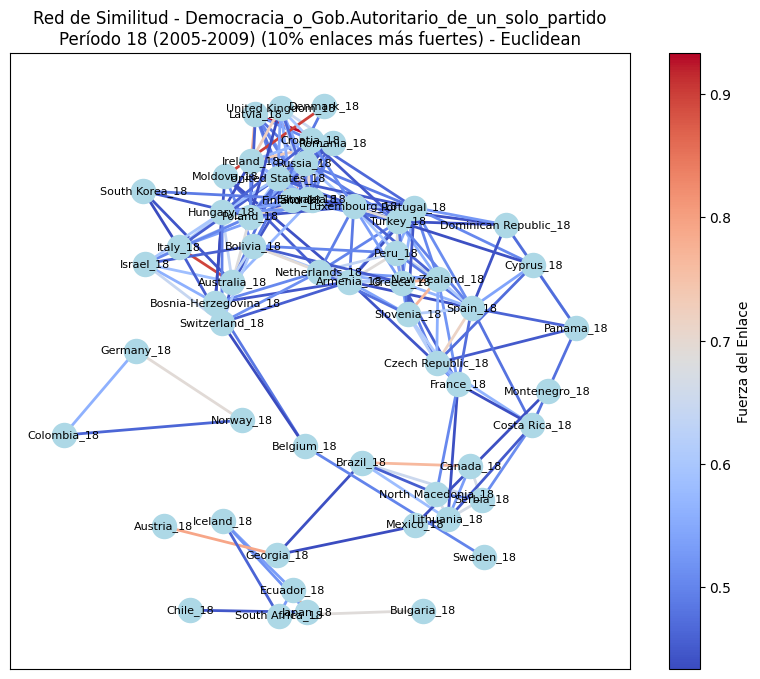

Se identificaron 7 clusters para el aspecto 'Democracia_o_Gob.Autoritario_de_un_solo_partido'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9888/1363358268.py:61: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


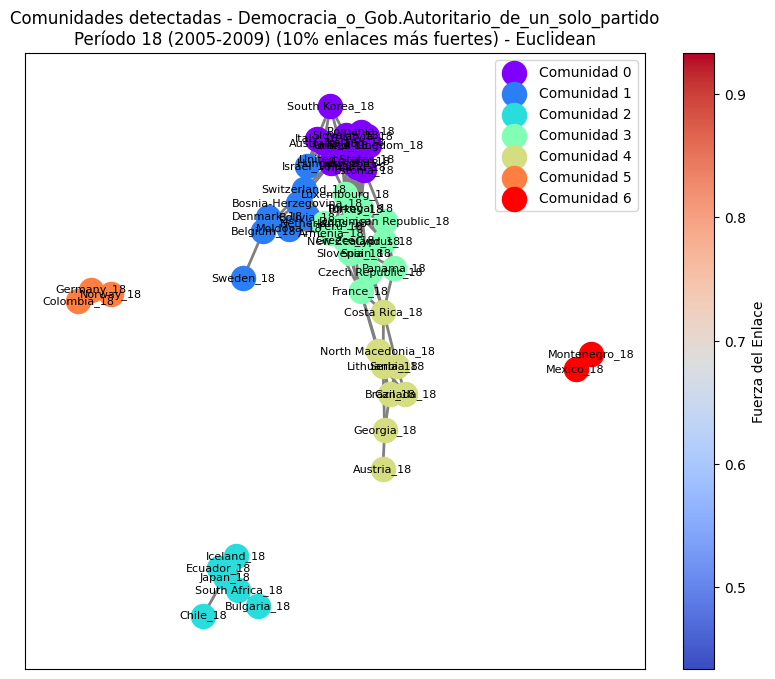

Chile pertenece a la Comunidad 2, que incluye 6 países:
['Bulgaria_18', 'Chile_18', 'Ecuador_18', 'Iceland_18', 'Japan_18', 'South Africa_18']
Comunidad 0 incluye 15 países:
['Australia_18', 'Croatia_18', 'Estonia_18', 'Finland_18', 'Hungary_18', 'Ireland_18', 'Italy_18', 'Latvia_18', 'Poland_18', 'Romania_18', 'Russia_18', 'Slovakia_18', 'South Korea_18', 'United Kingdom_18', 'United States_18']
Comunidad 1 incluye 8 países:
['Belgium_18', 'Bolivia_18', 'Bosnia-Herzegovina_18', 'Denmark_18', 'Israel_18', 'Moldova_18', 'Sweden_18', 'Switzerland_18']
Comunidad 3 incluye 15 países:
['Armenia_18', 'Cyprus_18', 'Czech Republic_18', 'Dominican Republic_18', 'France_18', 'Greece_18', 'Luxembourg_18', 'Netherlands_18', 'New Zealand_18', 'Panama_18', 'Peru_18', 'Portugal_18', 'Slovenia_18', 'Spain_18', 'Turkey_18']
Comunidad 4 incluye 8 países:
['Austria_18', 'Brazil_18', 'Canada_18', 'Costa Rica_18', 'Georgia_18', 'Lithuania_18', 'North Macedonia_18', 'Serbia_18']
Comunidad 5 incluye 3 países

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9888/1363358268.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9888/1363358268.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


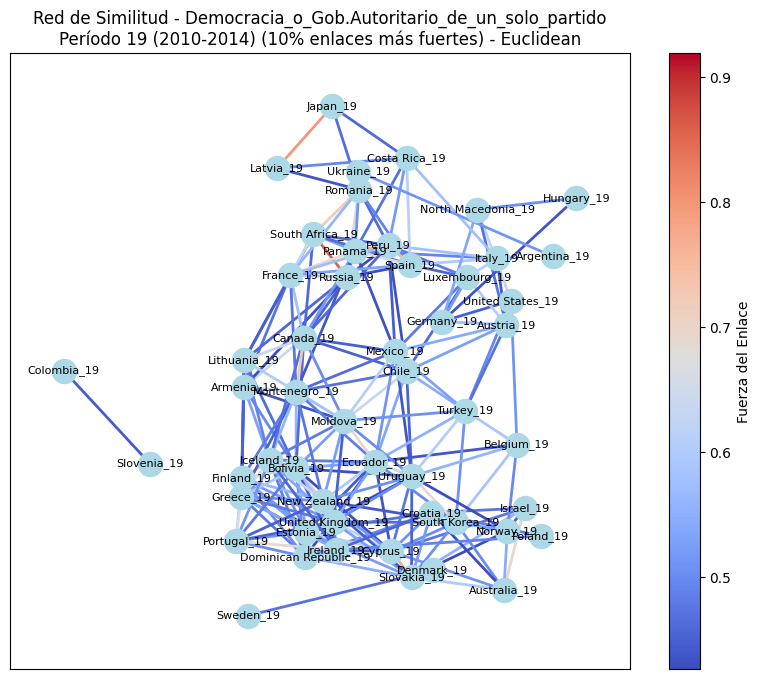

Se identificaron 7 clusters para el aspecto 'Democracia_o_Gob.Autoritario_de_un_solo_partido'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9888/1363358268.py:61: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


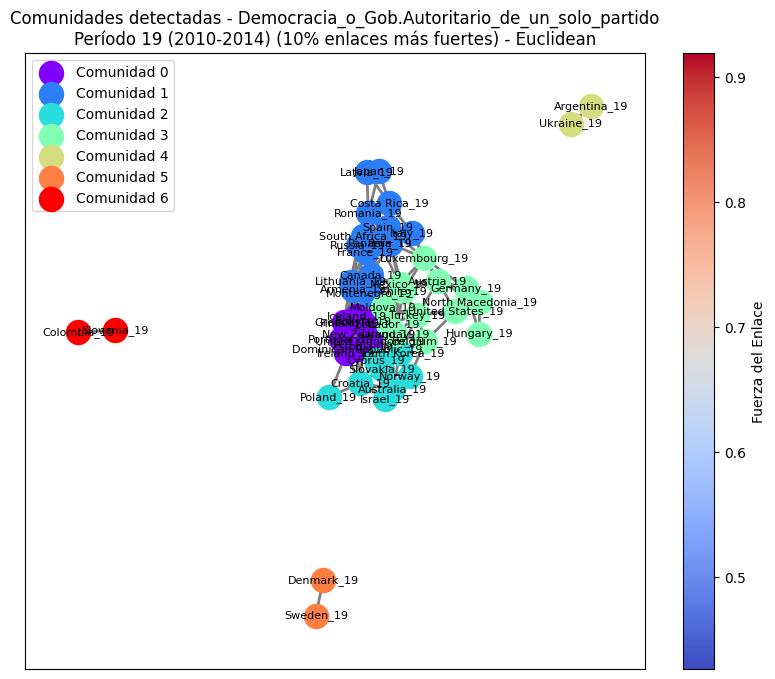

Chile pertenece a la Comunidad 3, que incluye 13 países:
['Austria_19', 'Belgium_19', 'Chile_19', 'Ecuador_19', 'Germany_19', 'Hungary_19', 'Luxembourg_19', 'Mexico_19', 'Moldova_19', 'North Macedonia_19', 'Turkey_19', 'United States_19', 'Uruguay_19']
Comunidad 0 incluye 10 países:
['Bolivia_19', 'Dominican Republic_19', 'Estonia_19', 'Finland_19', 'Greece_19', 'Iceland_19', 'Ireland_19', 'New Zealand_19', 'Portugal_19', 'United Kingdom_19']
Comunidad 1 incluye 15 países:
['Armenia_19', 'Canada_19', 'Costa Rica_19', 'France_19', 'Italy_19', 'Japan_19', 'Latvia_19', 'Lithuania_19', 'Montenegro_19', 'Panama_19', 'Peru_19', 'Romania_19', 'Russia_19', 'South Africa_19', 'Spain_19']
Comunidad 2 incluye 8 países:
['Australia_19', 'Croatia_19', 'Cyprus_19', 'Israel_19', 'Norway_19', 'Poland_19', 'Slovakia_19', 'South Korea_19']
Comunidad 4 incluye 2 países:
['Argentina_19', 'Ukraine_19']
Comunidad 5 incluye 2 países:
['Denmark_19', 'Sweden_19']
Comunidad 6 incluye 2 países:
['Colombia_19', '

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9888/1363358268.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9888/1363358268.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


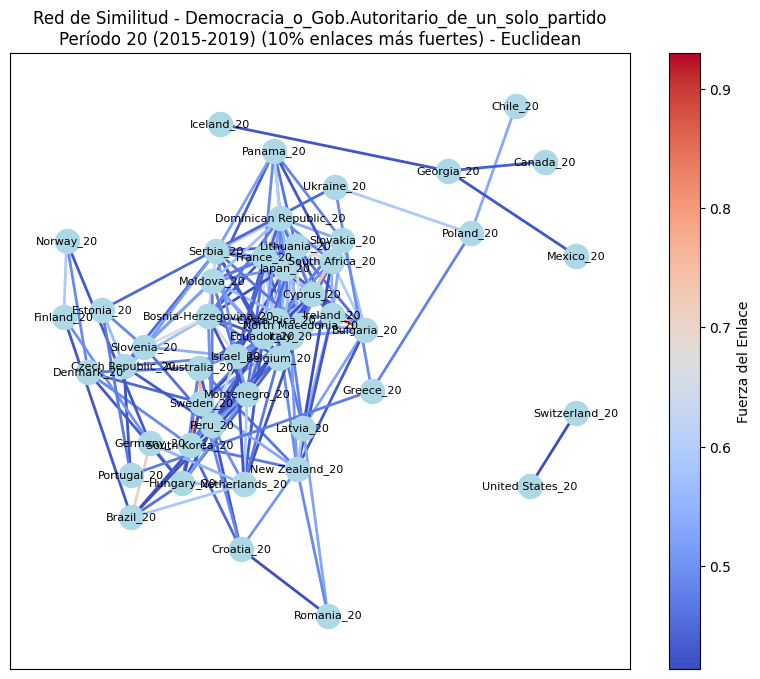

Se identificaron 6 clusters para el aspecto 'Democracia_o_Gob.Autoritario_de_un_solo_partido'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9888/1363358268.py:61: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


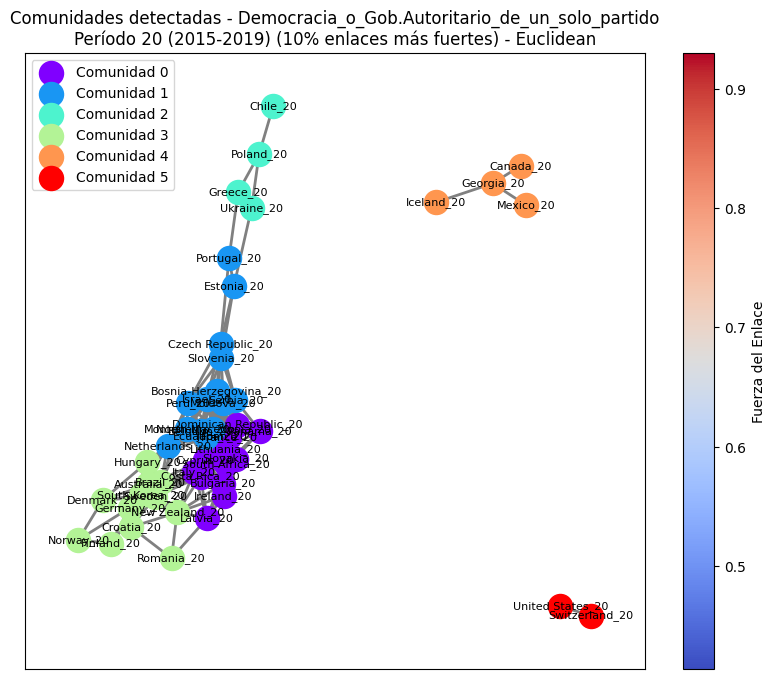

Chile pertenece a la Comunidad 2, que incluye 4 países:
['Chile_20', 'Greece_20', 'Poland_20', 'Ukraine_20']
Comunidad 0 incluye 13 países:
['Bulgaria_20', 'Costa Rica_20', 'Cyprus_20', 'Dominican Republic_20', 'France_20', 'Ireland_20', 'Italy_20', 'Japan_20', 'Latvia_20', 'Lithuania_20', 'Panama_20', 'Slovakia_20', 'South Africa_20']
Comunidad 1 incluye 14 países:
['Belgium_20', 'Bosnia-Herzegovina_20', 'Czech Republic_20', 'Ecuador_20', 'Estonia_20', 'Israel_20', 'Moldova_20', 'Montenegro_20', 'Netherlands_20', 'North Macedonia_20', 'Peru_20', 'Portugal_20', 'Serbia_20', 'Slovenia_20']
Comunidad 3 incluye 12 países:
['Australia_20', 'Brazil_20', 'Croatia_20', 'Denmark_20', 'Finland_20', 'Germany_20', 'Hungary_20', 'New Zealand_20', 'Norway_20', 'Romania_20', 'South Korea_20', 'Sweden_20']
Comunidad 4 incluye 4 países:
['Canada_20', 'Georgia_20', 'Iceland_20', 'Mexico_20']
Comunidad 5 incluye 2 países:
['Switzerland_20', 'United States_20']

=== Análisis para el período: 21 ===


---

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9888/1363358268.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9888/1363358268.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


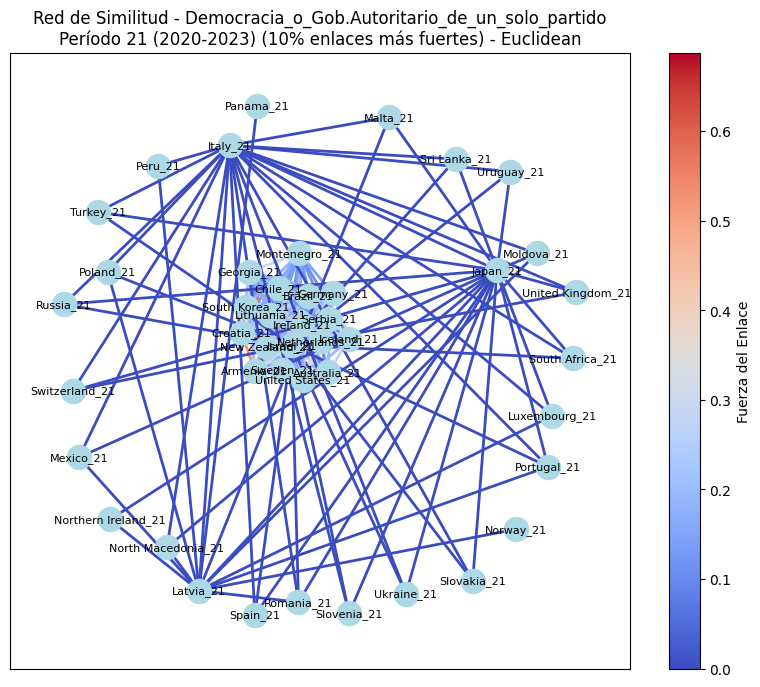

Se identificaron 28 clusters para el aspecto 'Democracia_o_Gob.Autoritario_de_un_solo_partido'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9888/1363358268.py:61: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


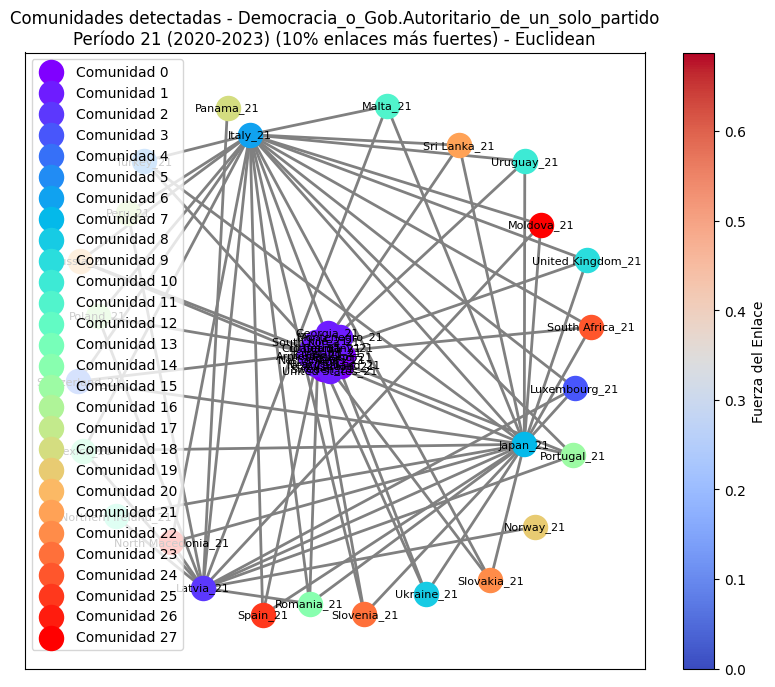

Chile pertenece a la Comunidad 1, que incluye 12 países:
['Armenia_21', 'Brazil_21', 'Chile_21', 'Croatia_21', 'Georgia_21', 'Germany_21', 'Israel_21', 'Lithuania_21', 'Montenegro_21', 'Netherlands_21', 'South Korea_21', 'United States_21']
Comunidad 0 incluye 6 países:
['Australia_21', 'Iceland_21', 'Ireland_21', 'New Zealand_21', 'Serbia_21', 'Sweden_21']
Comunidad 2 incluye 1 países:
['Latvia_21']
Comunidad 3 incluye 1 países:
['Luxembourg_21']
Comunidad 4 incluye 1 países:
['Switzerland_21']
Comunidad 5 incluye 1 países:
['Turkey_21']
Comunidad 6 incluye 1 países:
['Italy_21']
Comunidad 7 incluye 1 países:
['Japan_21']
Comunidad 8 incluye 1 países:
['Ukraine_21']
Comunidad 9 incluye 1 países:
['United Kingdom_21']
Comunidad 10 incluye 1 países:
['Uruguay_21']
Comunidad 11 incluye 1 países:
['Malta_21']
Comunidad 12 incluye 1 países:
['Northern Ireland_21']
Comunidad 13 incluye 1 países:
['Mexico_21']
Comunidad 14 incluye 1 países:
['Romania_21']
Comunidad 15 incluye 1 países:
['Por

,Periodo,Promedio_Betweenness_Centrality
0,14,0.0136
1,15,0.0210
2,16,0.0313
3,17,0.0289
4,18,0.0207
5,19,0.0247
6,20,0.0289
7,21,3545.1579


In [12]:
# Períodos a iterar
periodos = [14, 15, 16, 17, 18, 19, 20, 21]
porcentaje = 10
pearsonsino = False  # Cambiar a True para incluir análisis de Pearson

# Lista para almacenar los resúmenes de todos los períodos
resumen_periodos = []

# Iterar sobre los períodos
for periodo in periodos:
    print(f"\n=== Análisis para el período: {periodo} ===\n")
    
    # Lista para almacenar los resúmenes por período
    resumen_aspectos = []
    
    # Iterar sobre todos los aspectos en el DataFrame df_aspectos
    for aspecto in df_aspectos['aspecto']:
        print(f"\n--- Analizando aspecto: {aspecto} ---\n")
        
        if pearsonsino:
            # Calcular similitudes usando Pearson
            df_similarity_pearson = calcular_similitudes_todos_paises(
                df_5_extended, 
                df_aspectos[df_aspectos['aspecto'] == aspecto], 
                tipo_similitud='pearson', 
                periodo=periodo
            )
            resumen_pearson, _ = generar_red_y_calcular_metricas(
                df_similarity_pearson, 
                aspecto=aspecto, 
                tipo_similitud='Pearson', 
                porcentaje=porcentaje, 
                periodo=periodo
            )
            resumen_aspectos.append(resumen_pearson)
        
        # Calcular similitudes usando Euclidean
        df_similarity_euclidean = calcular_similitudes_todos_paises(
            df_5_extended, 
            df_aspectos[df_aspectos['aspecto'] == aspecto], 
            tipo_similitud='euclidean', 
            periodo=periodo
        )
        resumen_euclidean, _ = generar_red_y_calcular_metricas(
            df_similarity_euclidean, 
            aspecto=aspecto, 
            tipo_similitud='Euclidean', 
            porcentaje=porcentaje, 
            periodo=periodo
        )
        resumen_aspectos.append(resumen_euclidean)
    
    # Crear el DataFrame resumen para el período
    df_resumen_periodo = pd.DataFrame(resumen_aspectos)
    df_resumen_periodo['Periodo'] = periodo
    
    # Calcular el promedio de Betweenness Centrality para el período
    promedio_betweenness = df_resumen_periodo['Promedio_Betweenness_Centrality'].mean()
    resumen_periodos.append({'Periodo': periodo, 'Promedio_Betweenness_Centrality': promedio_betweenness})

# Crear un DataFrame resumen para todos los períodos
df_resumen_final = pd.DataFrame(resumen_periodos)

# Identificar el período con el máximo promedio de Betweenness Centrality
periodo_max_betweenness = df_resumen_final.loc[
    df_resumen_final['Promedio_Betweenness_Centrality'].idxmax()
]

# Imprimir el resultado
print("\n\n\nRESUMEN DE CENTRALIDADES")
print("Período con el máximo promedio de Betweenness Centrality:")
print(periodo_max_betweenness)

# Mostrar el DataFrame resumen de todos los períodos
display(df_resumen_final)
